### Cellpose Blur Experiment (diameter=80)

One hypothesis is that in many training sets used for generalist models there is ambiguity as to how out of focus 

- Checks environment (Torch/CUDA) and imports the correct Cellpose model (v3/v4).
- Choose an image by number from a small list.
- Runs segmentation across blur sigmas at fixed diameter=80.
- Visualizes overlays and saves the figure to `figures/`.
- Optionally opens napari to compare sigma=0 vs sigma=8.

Tip: Use the Pixi kernel for GPU-enabled runs (see README).

### Quick check: environment versions

This cell verifies your Python/Torch environment. If CUDA is available it will be reported.

In [1]:
# Environment check
import torch
import numpy as np

print("Torch version:", torch.__version__)
print("NumPy version:", np.__version__)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

print("cuDNN available:", torch.backends.cudnn.is_available())
print("cuDNN version:", torch.backends.cudnn.version())

Torch version: 2.6.0
NumPy version: 1.26.4
CUDA available: True
GPU name: NVIDIA GeForce RTX 3090
cuDNN available: True
cuDNN version: 91002


### Import cellpose

... and check major version.  Version 4 is the sam version.  Earlier versions are built on unets.

In [2]:
import cellpose
import os
import matplotlib.pyplot as plt
from cellpose import models
from skimage.io import imread
from skimage.filters import gaussian
from tnia.plotting.plt_helper import mask_overlay

major_number = cellpose.version.split('.')[0]
print(f"Cellpose version: {cellpose.version} (major number: {major_number})")

if major_number == '3':
    model = models.Cellpose(gpu=True, model_type='cyto2')
elif major_number == '4':
    model = models.CellposeModel(gpu=True)

Cellpose version: 4.0.8 (major number: 4)


### Load and display example image

Available images:
[0] Snap_060 (2).jpg
[1] Snap_055.jpg
[2] TestHidden_005.bmp
[3] Snap_061 (2).jpg
[4] BloodImage_00134_jpg.rf.0d9da503b62e0034a2819a39cce7e7d9.jpg
[5] BloodImage_00154_jpg.rf.e5b45569e9cbede1ed36f82f14566c29.jpg
Selected index: 0
Using image: ..\\..\\..\\reproducible-dl-seg-article\\data\\Blood cell Cancer [ALL]\\benign\\Snap_060 (2).jpg
Image tag: Snap_060 (2)
Loaded image shape: (768, 1024, 3), dtype: uint8


(-0.5, 1023.5, 767.5, -0.5)

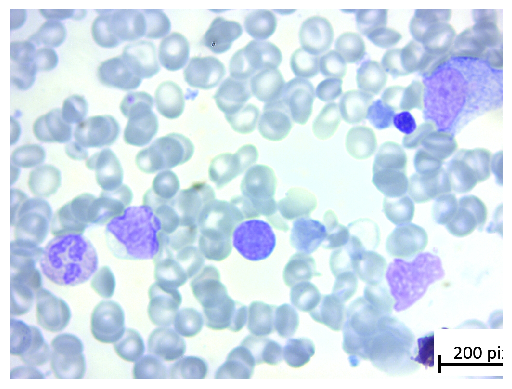

In [4]:
# Choose sample image by number (simple like 11_cellpose)
import os
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Available image options (indexed)
image_options = [
    r"..\\..\\..\\reproducible-dl-seg-article\\data\\Blood cell Cancer [ALL]\\benign\\Snap_060 (2).jpg",
    r"..\\..\\..\\reproducible-dl-seg-article\\data\\Blood cell Cancer [ALL]\\benign\\Snap_055.jpg",
    r"..\\..\\..\\reproducible-dl-seg-article\\data\\SOTA\\TestHidden_005.bmp",
    r"..\\..\\..\\reproducible-dl-seg-article\\data\\Blood cell Cancer [ALL]\\benign\\Snap_061 (2).jpg",
    r"..\\..\\..\\reproducible-dl-seg-article\\data\\addhopin blood cells\\test\\images\\BloodImage_00134_jpg.rf.0d9da503b62e0034a2819a39cce7e7d9.jpg",
    r"..\\..\\..\\reproducible-dl-seg-article\\data\\addhopin blood cells\\test\\images\\BloodImage_00154_jpg.rf.e5b45569e9cbede1ed36f82f14566c29.jpg",
]

# Index guide (set selection_index below):
# [0] Snap_060 (2).jpg
# [1] Snap_055.jpg
# [2] TestHidden_005.bmp
# [3] Snap_061 (2).jpg
# [4] BloodImage_00134_....jpg
# [5] BloodImage_00154_....jpg

# Choose by number: change this to desired index
selection_index =  0

print("Available images:")
for i, p in enumerate(image_options):
    print(f"[{i}] {os.path.basename(p)}")
print(f"Selected index: {selection_index}")

image_path = image_options[selection_index]
image_name = os.path.splitext(os.path.basename(image_path))[0]
print("Using image:", image_path)
print("Image tag:", image_name)

img = imread(image_path)

if len(img.shape) == 2:
    img = np.expand_dims(img, axis=2)
    img = np.repeat(img, 3, axis=2)

print(f"Loaded image shape: {img.shape}, dtype: {img.dtype}")
plt.imshow(img); plt.axis('off')

### Run Cellpose with fixed diameter=80 across blur levels

In [5]:
# Evaluate model with fixed diameter across blur levels
diameter_fixed = 80
blur_sigmas = [0, 1, 2, 4, 8]

# Convert to float [0,1] for filtering/segmentation
if np.issubdtype(img.dtype, np.integer):
    img_float = img.astype(np.float32) / np.iinfo(img.dtype).max
else:
    img_float = img.astype(np.float32)

# Store blurred images and results
blurred_by_sigma = {}  # sigma -> blurred image
results_by_blur = {}   # sigma -> (masks, flows, styles)

for s in blur_sigmas:
    if img_float.ndim == 3 and img_float.shape[2] >= 3:
        blurred = gaussian(img_float, sigma=s, channel_axis=2)
    else:
        blurred = gaussian(img_float, sigma=s)

    blurred_by_sigma[s] = blurred
    # Run Cellpose on blurred image with fixed diameter
    results_by_blur[s] = model.eval(blurred, diameter=diameter_fixed)

### Plot overlays for each blur level and save

Saved overlays figure to: figures\cellpose_overlays_Snap_060_(2)_v4.0.8_blur.png


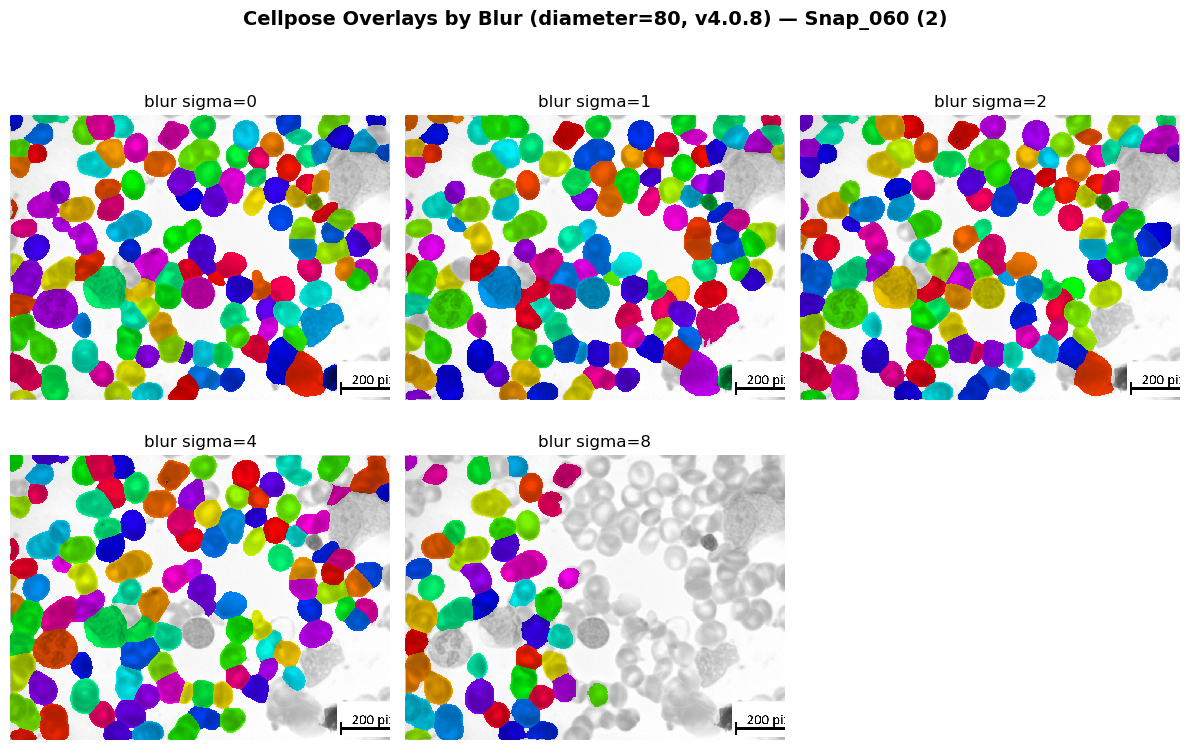

In [6]:
# Build overlays for each blur level (overlay on original image for consistent view)
overlays = []
labels = []

for s in blur_sigmas:
    res = results_by_blur[s]
    overlays.append(mask_overlay(img, res[0]))  # use original image for overlay
    labels.append(f"blur sigma={s}")

# Plot overlays in a grid
n = len(overlays)
cols = 3
rows = (n + cols - 1) // cols
fig = plt.figure(figsize=(4 * cols, 4 * rows))
for i, (ov, lbl) in enumerate(zip(overlays, labels), start=1):
    ax = plt.subplot(rows, cols, i)
    ax.imshow(ov)
    ax.set_title(lbl)
    ax.axis('off')

# Figure title with Cellpose version, image, and diameter
fig.suptitle(f"Cellpose Overlays by Blur (diameter={diameter_fixed}, v{cellpose.version}) — {image_name}", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure to figures/ with 'blur' in filename
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
version_tag = cellpose.version.replace(' ', '_')
image_tag = image_name.replace(' ', '_')
outfile = os.path.join(figures_dir, f"cellpose_overlays_{image_tag}_v{version_tag}_blur.png")
fig.savefig(outfile, dpi=200, bbox_inches='tight')
print(f"Saved overlays figure to: {outfile}")

plt.show()

In [ ]:
# Simple napari viewer: show blur 0 and blur 8 masks
import numpy as np

try:
    import napari
except ImportError as e:
    raise RuntimeError("napari is required for this cell. Install via 'pip install napari'.") from e

mask_sigma0 = results_by_blur[0][0]
mask_sigma8 = results_by_blur[8][0]

viewer = napari.Viewer()
viewer.add_image(img, name=f"Original ({image_name})")
viewer.add_image(blurred_by_sigma[8], name=f"Blurred (sigma=8)")
viewer.add_labels(mask_sigma0.astype(np.int32), name=f"Masks (sigma=0, d={diameter_fixed})")
viewer.add_labels(mask_sigma8.astype(np.int32), name=f"Masks (sigma=8, d={diameter_fixed})")

napari.run()